The MNIST consists of 4 major parts:


1.   Training dataset image which contains 60000 examples

1.   Traing dataset labels which consists of 60000 labels
2.   Test dataset images which contains 10000 examples


2.   Test dataset label which contains 10000 labels


The training dataset consists of handwritten digits from 250 various people and 50% high school students and 50% employees. The test dataset consists of handwritten digits from avarious people following the same split.


In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In scikit learn the fetch_openml functions downloads the MNIST dataset from Open ML as pandas DataFrame and Series objects, which is why we use the .values attribute to obtain the underlying Numpy arrays. The nxm dimensional X array consists of 70000 images with 784 pixels each, and the y array stores the corresponding 70000 class lables.

It is time to implement the code to make sure that we are correct.

In [2]:
print(X.shape)

(70000, 784)


In [3]:
print(y.shape)

(70000,)


The images in the MNIST dataset contains 28x28 pixels and each pixel is represented by a grayscale intensity value. Here fech_openml already unrolled the 28x28 pixels into 1-dimensional row vectors which represent the rows in our X array (784 per row or image) above. The second array (y) returned by the fetch_openml function consists of the corresponding target variable the class labels (integers 0-9) of the handwrriten digits.

It is a time to normalize the pixels values in MNIST to range from -1 to 1 (originally from 0 to 255)

In [4]:
# TODO: Normalize X so that pixel values are scaled from [0, 255] to [-1, 1]
# Hint: first divide by 255, then shift and scale.
X = (X / 255.0 - 0.5) * 2


The reason behind this is theat the graident based optimization is much more stable.nWe did scale the images on a pixel-by-pixel basis. When working with image pixels, centering them at 0 and rescaling them to a [-1,1] range is also common and usually works well in practice.

To get an idea of how those images in MNIST look, it is a time to write visualization code.

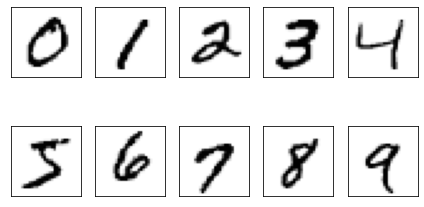

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

We can also plot multiple examples of the same digit to see how different the handwritting for each really is.

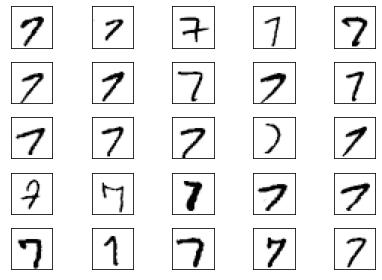

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Finally it is a time to divide the dataset into training, validation and test subsets.

In [5]:
from sklearn.model_selection import train_test_split

# Split X and y into a temporary set and a test set with 10,000 samples
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y)

# Split the temporary set into training and validation sets with 5,000 validation samples
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=42, stratify=y_temp)


The above code split the dataset such that 55000 images are used for training, 5000 images for validation and 10000 images for testing.

We will implement the MLP from scratch to classify the imaegs in the MNIST. To keep things simple, we will implement an MLP with only 1 hidden layer.

In [6]:
import numpy as np

# Implement the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Convert integer labels to one-hot encoded format
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        # set the correct index to 1
        ary[i, val] = 1
    return ary


As can be seen from the above code, we just create 2 helper functions to compute the logistic sigmoid activation and to convert integer class label arrays to one-hot encoded labels.

It is a time to implement NeuralNet MLP. There are 3 main class methods, .__init()__, .forward() and .backward().

In [7]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # initialize hidden layer weights and biases
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_features, num_hidden))
        self.bias_h = np.zeros(num_hidden)

        # initialize output layer weights and biases
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_classes))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        z_h = np.dot(x, self.weight_h) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        z_out = np.dot(a_h, self.weight_out) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # ---- Output layer ----
        d_loss__d_a_out = (a_out - y_onehot)
        d_a_out__d_z_out = a_out * (1 - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_loss__dw_out = np.dot(a_h.T, delta_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        # ---- Hidden layer ----
        d_loss__a_h = np.dot(delta_out, self.weight_out.T)
        d_a_h__d_z_h = a_h * (1 - a_h)
        delta_h = d_loss__a_h * d_a_h__d_z_h

        d_loss__d_w_h = np.dot(x.T, delta_h)
        d_loss__d_b_h = np.sum(delta_h, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)


The __init__ constructor instantiates the weight matrices and bias vectors for the hidden and the output layer. We will implement the forward method to make prediction.

The forward method takes in 1 or more training examples and returns the prediction. In fact it returns both the activation values from the hidden layer and the output layer, a_h and a_out. While a_out represents the class-membership probabilities that we can convert to class labels, which we care about, we also need the activation values from the hidden layer a_h to optimize the model parameters that is the weight and bias units of the hidden and output layer.

The backward method implements so-called backprobagation algorithm, which calculates the gradients of the loss with respect to the weight and bias parameters. Similar to Adaline (https://towardsdatascience.com/adaline-neural-networks-the-origin-of-gradient-descent-783ed05d7c18), these graidents are then used to update these parameters via gradient descent. Note that multilayer NNs are more complex than their single-layer siblings. The backward method is a way for computing graidents that are used for the gradient descent updates. for simplicity, the loss function this derivation is based on is the smae MSE loss used in Adaline.

In the NeuralNetMLP class, this object-oriented implementation  differs from the familiar scikit-learn API that is centered around the .fit() and .predict() emthods. Instead te main  methods of the NeuralNetMLP class are the .forward() and .backward() methods. One of the reasons behind this is that it makes a complex neural network a bit easier to understand in terms of how the information flows through the networks.

It is a time to implement the NeuralNetMLP class

In [8]:
# Create a NeuralNetMLP with 28*28 input features,
# 50 hidden units, and 10 output classes
model = NeuralNetMLP(
    num_features=28*28,
    num_hidden=50,
    num_classes=10
)


The model accepts MNIST images reshaped into 784-dimensional vectors (in the format of X_train, X_valid or X_test) for 10 integer classes (digits 0-9). The hidden layer consists of 50 nodes. Also we did use the sigmoid activation function after the first hidden layer and output layer to keep things simple.

# Implementing training method.

The first step is to define some helper functions for data loading. The second step is to embed these functions into the training loop that iterates over the dataset in multiple epochs. The first function is to define a mini-batch generator which takes in our datasets and divides it into mini-batches of a desired size for stochastic gradient descent traing.

In [9]:
# set number of training epochs
num_epochs = 50

# set minibatch size
minibatch_size = 64

# implement minibatch generator
def minibatch_generator(X, y, minibatch_size):
    # create shuffled indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # loop through data in steps of minibatch_size
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        # select minibatch indices
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        # yield minibatch of data and labels
        yield X[batch_idx], y[batch_idx]


We will write some codes that iterate through the dataset and then we will print the dimension of the minibatch.

In [10]:
# iterate over training epochs
for i in range(num_epochs):
    # create minibatch generator
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size
    )

    # loop over minibatches
    for X_train_mini, y_train_mini in minibatch_gen:
        break   # remove later once training code is added

    break   # remove later once training code is added

# print shapes of minibatch data and labels
print(X_train_mini.shape)
print(y_train_mini.shape)


(64, 784)
(64,)


As can be seen from the above result, the network returns mini-batches of size 100 as intended.

In the next setp we will define our loss function and performance metric that we cna use to monitor the training process and evaluate the model.

In [11]:
# implement mean squared error loss
def mse_loss(targets, probas, num_labels=10):
    # convert integer targets to one-hot vectors
    onehot_targets = int_to_onehot(targets, num_labels)

    # compute mean squared error
    return np.mean((onehot_targets - probas) ** 2)


# implement accuracy metric
def accuracy(targets, predicted_labels):
    # compare predicted labels with true targets
    return np.mean(predicted_labels == targets)


Next we need to test he above functiona dn compute the initial validation set MSE and accuracy of the model.

In [12]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')


Initial validation MSE: 0.2


In [13]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation accuracy: 9.0%


model.forward() returns the hudden and output layer activations. Remeber that we have 10 output nodes (one corresponding to each unique class label). Hence, when computing the MSE, we first converted the class labels into one-hot encoded class labels in the mse_loss() function. In pracitce it does not make a difference whether we average over the row or the columns of the squared-differentce matrix first, so we simply call np.mean() without any axis specification so that it returns a scalar.

The output layer activations, since we used the logistic function, are values in the range [0,1]. For each input, the output layer produces 10 values in the range [0,1], so we used the np.argmax() function to select the index position of the largest value, which yields the predicted class label. We then compared the true lables with the predicted class labels to compute the accuracy via the accuracy() function we did defined. As can be seen from the above ouput, the accuracy is not very high. However, given that we have a balanced dataset with 10 classes. a prediction accuracy of approximate 10% is what we would expect for an untraied model producing random predictions.

Using the boave code, we can compute the performance on. for example, the whole training set if we provide y_trian as input to targets and the predicted labels from feeding the model with X_train. However, in pracitce, our computer memory is usually a limiting factor for how much data the model can ingest in 1 forward pass (due to the large matrix multiplications). Hence we are defining our MSE and accuracy computation based on our previous mini-batch generator.

In [14]:
# compute MSE and accuracy over dataset using minibatches
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0

    # create minibatch generator
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        # forward pass through network
        _, probas = nnet.forward(features)

        # compute predicted labels
        predicted_labels = np.argmax(probas, axis=1)

        # convert targets to one-hot
        onehot_targets = int_to_onehot(targets, num_labels)

        # compute MSE loss for this batch
        loss = np.mean((onehot_targets - probas) ** 2)

        # accumulate correct predictions
        correct_pred += np.sum(predicted_labels == targets)

        # accumulate number of examples
        num_examples += targets.shape[0]

        # accumulate batch MSE (weighted by batch size)
        mse += loss * targets.shape[0]

    # average MSE over all examples
    mse = mse / num_examples

    # compute accuracy
    acc = correct_pred / num_examples

    return mse, acc


Before we implement the training loop, let's test the function and compute the initial traing set MSE and accuracy of the model we instantiated and make sure it works as intended.

In [15]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.0%


As can be seen from the above reuslts, our generator appraoch produces the same results as the previously defiend MSE and accuracy functions.

In [16]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):  # iterate over number of epochs

        # create minibatch generator
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size=64)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            # forward pass
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            # backward pass
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            # update hidden layer weights and biases
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h

            # update output layer weights and biases
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        # compute training and validation metrics
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train, minibatch_size=100)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid, minibatch_size=100)
        train_acc, valid_acc = train_acc*100, valid_acc*100

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        # print epoch summary
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.4f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


On a high level, the train() function iterates over multiple epochs and in each epoch it is ised the minibatch_generator() function to iterate ove the wole training set in mini batches for stochastic gradient descent training. Inside the mini-batch generator for loop, we obtain the outputs from the model, a_h and a_out via its .forwad() method. Then, we compute the loss graidents via the model's backward() mthod. Using the loss gradietns, we update the wieghts by adding the negative gradient multiplied by the learning rate.

It is a time to execute this function to train the model for 50 epochs

In [17]:
# set random seed for reproducibility
np.random.seed(123)

# train the model and collect metrics
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model,       # model
    X_train,     # X_train
    y_train,     # y_train
    X_valid,     # X_valid
    y_valid,     # y_valid
    num_epochs=50,
    learning_rate=0.1
)


Epoch: 001/050 | Train MSE: 0.1000 | Train Acc: 14.35% | Valid Acc: 14.14%
Epoch: 002/050 | Train MSE: 0.1000 | Train Acc: 9.99% | Valid Acc: 9.98%
Epoch: 003/050 | Train MSE: 0.1000 | Train Acc: 10.20% | Valid Acc: 10.20%
Epoch: 004/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.74%
Epoch: 005/050 | Train MSE: 0.0999 | Train Acc: 9.75% | Valid Acc: 9.74%
Epoch: 006/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 007/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 008/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 009/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 010/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 011/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 012/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 013/050 | Train MSE: 0.1000 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 014/050 | Train MSE: 0.1000 | Train Acc:

The reason why we do need to print all this out put is that  in Neural netwrok traing it is useful to compare the training and validation accuracy. This will help us to judge whether the newrok model performs well given the architecture and hyperparameters. For example, if we observe a low training and validation accuracy, there is likely a problem with the training dataset or the hyperparameters' settings are not ideal.

**Evaluate our model**

In train(), we have collected the training loss and the training and validation accuracy for each epoch so that we can visualize the results using Matplotlib.

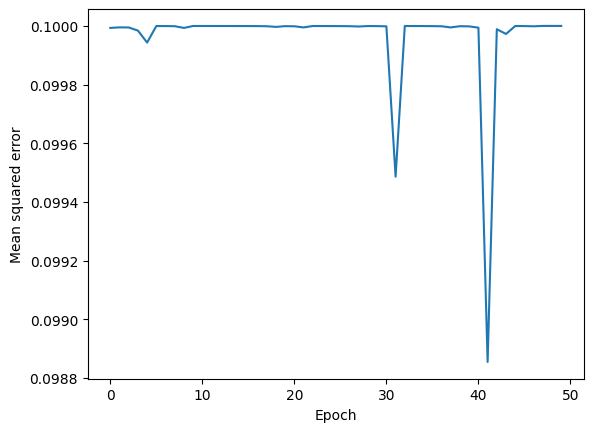

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

As can be seen from the above image, the loss decreased substaintially during the first 10 epochs and seems to slowly converge in the last 10 epochs. However, the small slope between epoch 40 and epoch 50 indicates that the loss would further decrease with training over additional epochs.

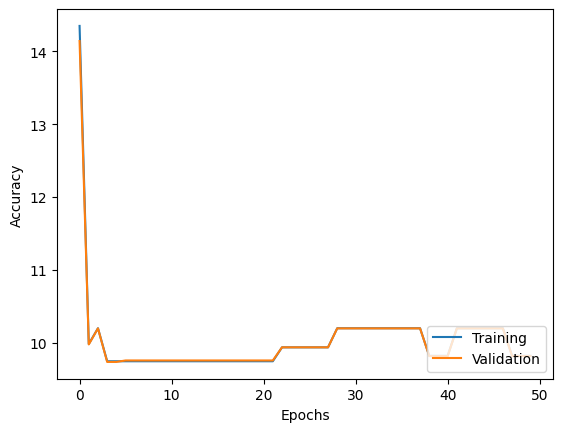

In [20]:
# It is a time to take a look at training and validation accuracy
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

As can be seen from the above rresult, the plot reveals that the gap between training adn validation accuracy increases as we train for more epochs. At approximately the 25th epoch, the training and validation accuracy valyes are almost equal and then the network starts to slightly overfit the training data.

In [21]:
# It is atime to evaluate the generalization performance of the model by calculating the prediction accurayc on the test set
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 9.82%


We can see that the test accuracy is very close to the validation set accuracy corresponding to the last epoch which is around 94.78%, which we reported during the training before. Moverover, the respective training accuracy is only minimally higher than at 95.61, reaffirming that our model only slightly overfits the training data.

It is a time to look at some of the images that our MLP struggles with by extracting and plotting the first 25 misclassified samples from the test set.

In [22]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

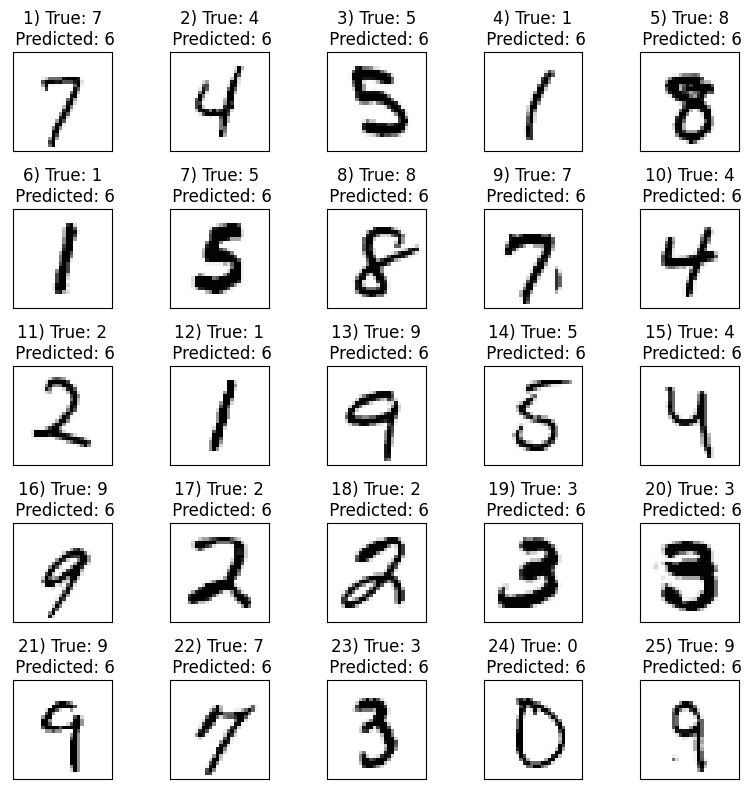

In [23]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

As can be seen from the above result, the network finds 7 challenging when they include a horizontal line. We can see that a 5x5 subplot matrix where the first number in the subtitles indicates the plot index, the second number represents the true class label (True) amd the third number stands for the predicted class label (predicted)